## Import Libraries

In [1]:
'''basics'''
import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join('..', 'src')))
sys.setrecursionlimit(20500)
import pandas as pd
import pickle5 as pickle
import numpy as np

'''Plotting'''
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

'''features'''
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import label_binarize

'''Classifiers'''
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB


'''Metrics/Evaluation'''
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from scipy import interp
from itertools import cycle
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn_hierarchical_classification.classifier import HierarchicalClassifier
from sklearn_hierarchical_classification.constants import ROOT
from sklearn_hierarchical_classification.metrics import h_fbeta_score, multi_labeled
from sklearn.pipeline import Pipeline


import warnings
warnings.filterwarnings('ignore')


## Import data and holdout data for prediction

In [2]:
df = pd.read_csv('../data/processed/encoded_labels/technical_area_1.csv')
df.columns

Index(['PIMS_ID', 'all_text_clean', 'all_text_clean_spacy', 'technical_area_1',
       '_access_and_benefit_sharing', '_agrobiodiversity',
       '_biodiversity_financing', '_ecosystem_based_adaptation',
       '_ecosystem_based_mitigation', '_small_island_dev_states_program_sids',
       '_wildlife_conservation', 'climate_change_adaptation_programme',
       'climate_information_and_early_warning_systems_ci_ews',
       'climate_resilient_access_to_water_supply_sanitation',
       'climate_resilient_integrated_water_resource_coastal_area_management',
       'cross_cutting_governance_and_learning',
       'cross_sectoral_climate_resilient_livelihoods',
       'ecosystem_based_adaptation', 'ecosystem_management_and_restoration',
       'ecosystems_and_biodiversity_programme', 'energy_access',
       'energy_efficiency', 'environmental_governance_programme',
       'fostering_food_security_and_resilient_agricultural_systems',
       'heavy_metals', 'mainstreaming_biodiversity',
       'm

In [3]:
df_labels = df.drop(['PIMS_ID', 'all_text_clean', 'all_text_clean_spacy', 'technical_area_1'], axis=1)
counts = []
categories = list(df_labels.columns.values)
for i in categories:
    counts.append((i, df_labels[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_inputs'])
df_stats

,category,number_of_inputs
0,_access_and_benefit_sharing,1
1,_agrobiodiversity,5
2,_biodiversity_financing,1
3,_ecosystem_based_adaptation,5
4,_ecosystem_based_mitigation,2
5,_small_island_dev_states_program_sids,3
6,_wildlife_conservation,5
7,climate_change_adaptation_programme,56
8,climate_information_and_early_warning_systems_...,16
9,climate_resilient_access_to_water_supply_sanit...,7


Text(0.5, 0, 'category')

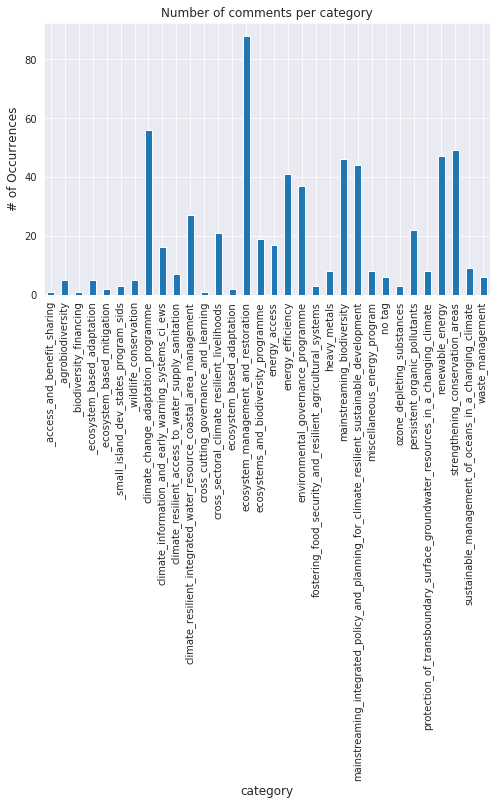

In [4]:
df_stats.plot(x='category', y='number_of_inputs', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

## How many comments have multi labels

Text(0.5, 0, '# of categories')

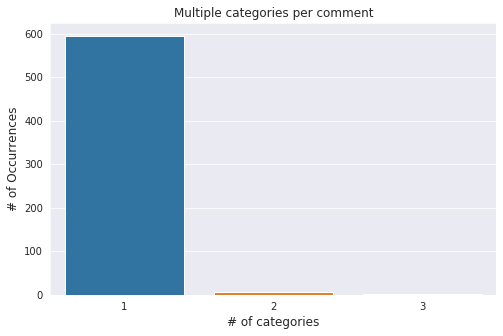

In [5]:
rowsums = df.iloc[:,4:].sum(axis=1)
x=rowsums.value_counts()
#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

## The distribution of the number of words in input texts

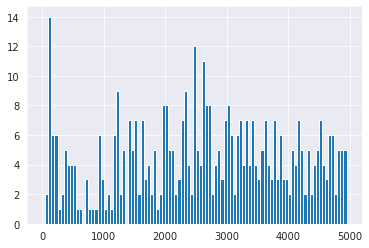

In [6]:
lens = df.all_text_clean.str.len()
lens.hist(bins = np.arange(0,5000,50))

## Holding out 5 rows from the original dataframe for prediction at the end

In [7]:
df_holdout = df.iloc[:5]

df = df.iloc[5:]

In [8]:
df.columns

Index(['PIMS_ID', 'all_text_clean', 'all_text_clean_spacy', 'technical_area_1',
       '_access_and_benefit_sharing', '_agrobiodiversity',
       '_biodiversity_financing', '_ecosystem_based_adaptation',
       '_ecosystem_based_mitigation', '_small_island_dev_states_program_sids',
       '_wildlife_conservation', 'climate_change_adaptation_programme',
       'climate_information_and_early_warning_systems_ci_ews',
       'climate_resilient_access_to_water_supply_sanitation',
       'climate_resilient_integrated_water_resource_coastal_area_management',
       'cross_cutting_governance_and_learning',
       'cross_sectoral_climate_resilient_livelihoods',
       'ecosystem_based_adaptation', 'ecosystem_management_and_restoration',
       'ecosystems_and_biodiversity_programme', 'energy_access',
       'energy_efficiency', 'environmental_governance_programme',
       'fostering_food_security_and_resilient_agricultural_systems',
       'heavy_metals', 'mainstreaming_biodiversity',
       'm

##  Features engineering

In [9]:
categories = ['_access_and_benefit_sharing', '_agrobiodiversity',
       '_biodiversity_financing', '_ecosystem_based_adaptation',
       '_ecosystem_based_mitigation', '_small_island_dev_states_program_sids',
       '_wildlife_conservation', 'climate_change_adaptation_programme',
       'climate_information_and_early_warning_systems_ci_ews',
       'climate_resilient_access_to_water_supply_sanitation',
       'climate_resilient_integrated_water_resource_coastal_area_management',
       'cross_cutting_governance_and_learning',
       'cross_sectoral_climate_resilient_livelihoods',
       'ecosystem_based_adaptation', 'ecosystem_management_and_restoration',
       'ecosystems_and_biodiversity_programme', 'energy_access',
       'energy_efficiency', 'environmental_governance_programme',
       'fostering_food_security_and_resilient_agricultural_systems',
       'heavy_metals', 'mainstreaming_biodiversity',
       'mainstreaming_integrated_policy_and_planning_for_climate_resilient_sustainable_development',
       'miscellaneous_energy_program', 'no tag', 'ozone_depleting_substances',
       'persistent_organic_pollutants',
       'protection_of_transboundary_surface_groundwater_resources_in_a_changing_climate',
       'renewable_energy', 'strengthening_conservation_areas',
       'sustainable_management_of_oceans_in_a_changing_climate',
       'waste_management']


#Creating the features (tf-idf weights) for the processed text
texts = df['all_text_clean'].astype('str')

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df = 2, 
                                   max_df = .95)

X = tfidf_vectorizer.fit_transform(texts)

#Turning the labels into numbers
y = pd.DataFrame(df, columns = categories)
#Dimenionality reduction. Only using the 100 best features er category

lsa = TruncatedSVD(n_components=100, 
                   n_iter=10, 
                   random_state=3)

X = lsa.fit_transform(X)


## Train multiple ML models / OneVsRest multi-label strategy

In [10]:
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])
#Creating a dict of the models
model_dict = {
              'Stochastic Gradient Descent' : OneVsRestClassifier(SGDClassifier(random_state=3, loss='log'), n_jobs=1),
              'Random Forest': OneVsRestClassifier(RandomForestClassifier(random_state=3), n_jobs=1),
              'Decsision Tree': OneVsRestClassifier(DecisionTreeClassifier(random_state=3), n_jobs=1),
              'AdaBoost': OneVsRestClassifier(AdaBoostClassifier(random_state=3), n_jobs=1),
              'Gaussian Naive Bayes': OneVsRestClassifier(GaussianNB(), n_jobs=1),
              'K Nearest Neighbor': OneVsRestClassifier(KNeighborsClassifier(), n_jobs=1)}


#Train test split with stratified sampling for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .3, 
                                                    shuffle = True,  
                                                    random_state = 3)
y_train = y_train.dropna(axis=1)
#Function to get the scores for each model in a df
def model_score_df(model_dict, X_train, X_test, y_train, y_test):   
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
    for k,v in model_dict.items():   
        model_name.append(k)
        v.fit(X_train, y_train)
        y_pred = v.predict(X_test)
        ac_score_list.append(accuracy_score(y_test, y_pred))
        p_score_list.append(precision_score(y_test, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
    return model_comparison_df


def printTable(myDict, colList=None, sep='\uFFFA'):
    """ Pretty print a list of dictionaries (myDict) as a dynamically sized table.
   If column names (colList) aren't specified, they will show in random order.
   sep: row separator. Ex: sep='\n' on Linux. Default: dummy to not split line.
   Author: Thierry Husson - Use it as you want but don't blame me.
   """
    if not colList: colList = list(myDict[0].keys() if myDict else [])
    myList = [colList] # 1st row = header
    for item in myDict: myList.append([str(item[col] or '') for col in colList])
    colSize = [max(map(len,(sep.join(col)).split(sep))) for col in zip(*myList)]
    formatStr = ' | '.join(["{{:<{}}}".format(i) for i in colSize])
    line = formatStr.replace(' | ','-+-').format(*['-' * i for i in colSize])
    item=myList.pop(0); lineDone=False
    while myList:
        if all(not i for i in item):
            item=myList.pop(0)
            if line and (sep!='\uFFFA' or not lineDone): print(line); lineDone=True
        row = [i.split(sep,1) for i in item]
        print(formatStr.format(*[i[0] for i in row]))
        item = [i[1] if len(i)>1 else '' for i in row]
        

from tabulate import tabulate        
lis = []
for category in categories:
    dic = {}
    dff = model_score_df(model_dict, X_train, X_test, y_train[category], y_test[category])
    # Using DataFrame.insert() to add a column
    dic['Category'] = category
    dic['#Inputs'] = df_stats.number_of_inputs[df_stats['category'] == category]
    dic['Classifiers'] = '    \n '.join(dff.model_name.apply(str).tolist())
    dic['accuracy_score'] = '    \n '.join(dff.accuracy_score.apply(str).tolist()) 
    dic['precision_score'] = '   \n '.join(dff.precision_score.apply(str).tolist())
    dic['recall_score'] = '    \n '.join(dff.recall_score.apply(str).tolist())
    dic['f1_score'] = '    \n '.join(dff.f1_score.apply(str).tolist())
    lis.append(dic)
    
#headers = ['Category', 'Classifiers', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
#print(tabulate(lis, tablefmt='html'))
header = lis[0].keys()
rows =  [x.values() for x in lis]
#print (tabulate(rows, header, tablefmt='html'))


In [11]:
print (tabulate(rows, header, tablefmt='html'))

<table>
<thead>
<tr><th>Category                                                                                  </th><th style="text-align: right;">  #Inputs</th><th>Classifiers  </th><th>accuracy_score  </th><th>precision_score  </th><th>recall_score  </th><th>f1_score  </th></tr>
</thead>
<tbody>
<tr><td>_access_and_benefit_sharing                                                               </td><td style="text-align: right;">        1</td><td>Stochastic Gradient Descent    
 Random Forest    
 Decsision Tree    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor              </td><td>0.9944444444444445    
 0.9944444444444445    
 0.9944444444444445    
 0.9944444444444445    
 0.9944444444444445    
 0.9944444444444445                 </td><td>0.49722222222222223   
 0.49722222222222223   
 0.49722222222222223   
 0.49722222222222223   
 0.49722222222222223   
 0.49722222222222223                  </td><td>0.5    
 0.5    
 0.5    
 0.5    
 0.5    
 0.5               

<table>
<thead>
<tr><th>Category                                                                                  </th><th style="text-align: right;">  #Inputs</th><th>Classifiers  </th><th>accuracy_score  </th><th>precision_score  </th><th>recall_score  </th><th>f1_score  </th></tr>
</thead>
<tbody>
<tr><td>_access_and_benefit_sharing                                                               </td><td style="text-align: right;">        1</td><td>Stochastic Gradient Descent    
 Random Forest    
 Decsision Tree    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor              </td><td>0.9944444444444445    
 0.9944444444444445    
 0.9944444444444445    
 0.9944444444444445    
 0.9944444444444445    
 0.9944444444444445                 </td><td>0.49722222222222223   
 0.49722222222222223   
 0.49722222222222223   
 0.49722222222222223   
 0.49722222222222223   
 0.49722222222222223                  </td><td>0.5  <br>  
 0.5    <br> 
 0.5    <br> 
 0.5    <br> 
 0.5    <br> 
 0.5               </td><td>0.4986072423398329    
 0.4986072423398329    
 0.4986072423398329    
 0.4986072423398329    
 0.4986072423398329    
 0.4986072423398329           </td></tr>
<tr><td>_agrobiodiversity                                                                         </td><td style="text-align: right;">        5</td><td>Stochastic Gradient Descent    
 Random Forest    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor    
 Decsision Tree              </td><td>0.9888888888888889    
 0.9888888888888889    
 0.9888888888888889    
 0.9888888888888889    
 0.9888888888888889    
 0.9777777777777777                 </td><td>0.49444444444444446   
 0.49444444444444446   
 0.49444444444444446   
 0.49444444444444446   
 0.49444444444444446   
 0.4943820224719101                  </td><td>0.5    <br> 
 0.5    <br> 
 0.5    <br> 
 0.5    <br> 
 0.5    <br> 
 0.4943820224719101               </td><td>0.49720670391061456    
 0.49720670391061456    
 0.49720670391061456    
 0.49720670391061456    
 0.49720670391061456    
 0.4943820224719101           </td></tr>
<tr><td>_biodiversity_financing                                                                   </td><td style="text-align: right;">        1</td><td>Stochastic Gradient Descent    
 Random Forest    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor    
 Decsision Tree              </td><td>1.0    <br> 
 1.0    <br> 
 1.0    <br> 
 1.0    <br> 
 1.0    <br> 
 0.9777777777777777                 </td><td>1.0   <br> 
 1.0   <br> 
 1.0   <br> 
 1.0   <br> 
 1.0   <br> 
 0.5                  </td><td>1.0    <br> 
 1.0    <br> 
 1.0    <br> 
 1.0    <br> 
 1.0    <br> 
 0.4888888888888889               </td><td>1.0   <br>  
 1.0    <br> 
 1.0    <br> 
 1.0    <br> 
 1.0    <br> 
 0.4943820224719101           </td></tr>
<tr><td>_ecosystem_based_adaptation                                                               </td><td style="text-align: right;">        5</td><td>Stochastic Gradient Descent    
 Random Forest    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor    
 Decsision Tree              </td><td>0.9888888888888889    
 0.9888888888888889    
 0.9888888888888889    
 0.9888888888888889    
 0.9888888888888889    
 0.9777777777777777                 </td><td>0.49444444444444446   
 0.49444444444444446   
 0.49444444444444446   
 0.49444444444444446   
 0.49444444444444446   
 0.4943820224719101                  </td><td>0.5    <br> 
 0.5    <br> 
 0.5    <br> 
 0.5    <br> 
 0.5    <br> 
 0.4943820224719101               </td><td>0.49720670391061456    
 0.49720670391061456    
 0.49720670391061456    
 0.49720670391061456    
 0.49720670391061456    
 0.4943820224719101           </td></tr>
<tr><td>_ecosystem_based_mitigation                                                               </td><td style="text-align: right;">        2</td><td>Stochastic Gradient Descent    
 Random Forest    
 Decsision Tree    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor              </td><td>0.9944444444444445    
 0.9944444444444445    
 0.9944444444444445    
 0.9944444444444445    
 0.9944444444444445    
 0.9944444444444445                 </td><td>0.49722222222222223   
 0.49722222222222223   
 0.49722222222222223   
 0.49722222222222223   
 0.49722222222222223   
 0.49722222222222223                  </td><td>0.5  <br>   
 0.5    <br> 
 0.5    <br> 
 0.5    <br> 
 0.5    <br> 
 0.5               </td><td>0.4986072423398329    
 0.4986072423398329    
 0.4986072423398329    
 0.4986072423398329    
 0.4986072423398329    
 0.4986072423398329           </td></tr>
<tr><td>_small_island_dev_states_program_sids                                                     </td><td style="text-align: right;">        3</td><td>Stochastic Gradient Descent    
 Random Forest    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor    
 Decsision Tree              </td><td>0.9888888888888889    
 0.9888888888888889    
 0.9888888888888889    
 0.9888888888888889    
 0.9888888888888889    
 0.9833333333333333                 </td><td>0.49444444444444446   
 0.49444444444444446   
 0.49444444444444446   
 0.49444444444444446   
 0.49444444444444446   
 0.49441340782122906                  </td><td>0.5    <br> 
 0.5    <br> 
 0.5    <br> 
 0.5    <br> 
 0.5    <br> 
 0.49719101123595505               </td><td>0.49720670391061456    
 0.49720670391061456    
 0.49720670391061456    
 0.49720670391061456    
 0.49720670391061456    
 0.4957983193277311           </td></tr>
<tr><td>_wildlife_conservation                                                                    </td><td style="text-align: right;">        5</td><td>Stochastic Gradient Descent    
 Random Forest    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor    
 Decsision Tree              </td><td>0.9944444444444445    
 0.9944444444444445    
 0.9944444444444445    
 0.9944444444444445    
 0.9944444444444445    
 0.9666666666666667                 </td><td>0.49722222222222223   
 0.49722222222222223   
 0.49722222222222223   
 0.49722222222222223   
 0.49722222222222223   
 0.49714285714285716                  </td><td>0.5   <br>  
 0.5    <br> 
 0.5    <br> 
 0.5    <br> 
 0.5    <br> 
 0.4860335195530726               </td><td>0.4986072423398329    
 0.4986072423398329    
 0.4986072423398329    
 0.4986072423398329    
 0.4986072423398329    
 0.4915254237288135           </td></tr>
<tr><td>climate_change_adaptation_programme                                                       </td><td style="text-align: right;">       56</td><td>K Nearest Neighbor    
 Stochastic Gradient Descent    
 Decsision Tree    
 Random Forest    
 AdaBoost    
 Gaussian Naive Bayes              </td><td>0.9888888888888889    
 0.9888888888888889    
 0.9833333333333333    
 0.9833333333333333    
 0.9833333333333333    
 0.9666666666666667                 </td><td>0.9375   <br> 
 0.9612736660929433   
 0.9303030303030303   
 0.9555504375863657   
 0.9555504375863657   
 0.8580246913580247                  </td><td>0.9939759036144578    
 0.9612736660929433    
 0.9582616179001722    
 0.9255593803786575    
 0.9255593803786575    
 0.9492254733218588               </td><td>0.9636363636363636    
 0.9612736660929433    
 0.9437441400145848    
 0.93993993993994    
 0.93993993993994    
 0.8971036585365855           </td></tr>
<tr><td>climate_information_and <br>  _early_warning_systems_ci_ews                                      </td><td style="text-align: right;">       16</td><td>Stochastic Gradient Descent    
 AdaBoost    
 K Nearest Neighbor    
 Decsision Tree    
 Gaussian Naive Bayes    
 Random Forest              </td><td>0.9833333333333333    
 0.9888888888888889    
 0.9833333333333333    
 0.9777777777777777    
 0.9388888888888889    
 0.9777777777777777                 </td><td>0.7471590909090908   
 0.994413407821229   
 0.7443820224719101   
 0.6610169491525424   
 0.5803571428571429   
 0.49162011173184356                  </td><td>0.827683615819209    
 0.6666666666666666    
 0.6638418079096046    
 0.6610169491525424    
 0.8050847457627118    
 0.4971751412429379               </td><td>0.7814649939295832    
 0.7471910112359551    
 0.6957746478873239    
 0.6610169491525424    
 0.6173913043478261    
 0.4943820224719101           </td></tr>
<tr><td>climate_resilient_access <br> _to_water_supply_sanitation                                       </td><td style="text-align: right;">        7</td><td>Stochastic Gradient Descent    
 Gaussian Naive Bayes    
 Decsision Tree    
 Random Forest    
 AdaBoost    
 K Nearest Neighbor              </td><td>0.9944444444444445    
 0.9944444444444445    
 0.9611111111111111    
 0.9888888888888889    
 0.9888888888888889    
 0.9888888888888889                 </td><td>0.9972067039106145   
 0.9972067039106145   
 0.5685383980181667   
 0.49444444444444446   
 0.49444444444444446   
 0.49444444444444446                  </td><td>0.75 <br>    
 0.75    <br> 
 0.7331460674157304  <br>    
 0.5    <br> 
 0.5    <br> 
 0.5               </td><td>0.8319327731092436    
 0.8319327731092436    
 0.6011396011396012    
 0.49720670391061456    
 0.49720670391061456    
 0.49720670391061456           </td></tr>
<tr><td>climate_resilient_integrated_ <br>  water_resource_coastal_area_management                       </td><td style="text-align: right;">       27</td><td>K Nearest Neighbor    
 AdaBoost    
 Decsision Tree    
 Gaussian Naive Bayes    
 Random Forest    
 Stochastic Gradient Descent              </td><td>0.9777777777777777<br>     
 0.95    <br> 
 0.9333333333333333    
 0.7944444444444444    
 0.9555555555555556 <br>    
 0.95                 </td><td>0.9080459770114943   
 0.6828571428571428   
 0.6075581395348837   
 0.5777457138007129   
 0.4777777777777778   
 0.4776536312849162                  </td><td>0.809593023255814    
 0.6162790697674418    
 0.6075581395348837    
 0.8328488372093024    <br> 
 0.5    
 0.49709302325581395               </td><td>0.8513625103220479    
 0.6408778541343383    
 0.6075581395348837    
 0.577384351798972    
 0.48863636363636365    
 0.48717948717948717           </td></tr>
<tr><td>cross_cutting_governance_and_learning                                                     </td><td style="text-align: right;">        1</td><td>Stochastic Gradient Descent    
 Random Forest    
 Decsision Tree    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor              </td><td>1.0    <br> 
 1.0    <br> 
 1.0    <br> 
 1.0    <br> 
 1.0    <br> 
 1.0                 </td><td>1.0   <br> 
 1.0   <br> 
 1.0   <br> 
 1.0   <br> 
 1.0   <br> 
 1.0                  </td><td>1.0   <br>  
 1.0    <br> 
 1.0    <br> 
 1.0    <br> 
 1.0    <br> 
 1.0               </td><td>1.0    <br> 
 1.0    <br> 
 1.0    <br> 
 1.0    <br> 
 1.0    <br> 
 1.0           </td></tr>
<tr><td>cross_sectoral_climate_ <br>  resilient_livelihoods                                              </td><td style="text-align: right;">       21</td><td>K Nearest Neighbor    
 Stochastic Gradient Descent    
 Gaussian Naive Bayes    
 AdaBoost    
 Decsision Tree    
 Random Forest              </td><td>0.9611111111111111    
 0.9777777777777777    
 0.9388888888888889    
 0.9666666666666667  <br>   
 0.95    <br> 
 0.9722222222222222                 </td><td>0.6580459770114943   
 0.9888268156424581   
 0.6190476190476191   
 0.655367231638418   
 0.5718390804597702   
 0.4861111111111111                  </td><td>0.6885714285714286  <br>   
 0.6    <br> 
 0.7742857142857142    
 0.5942857142857143    
 0.5857142857142857 <br>    
 0.5               </td><td>0.6717895285230528    
 0.6610169491525424    
 0.6604356028125536    
 0.6164772727272727    
 0.578015108101068    
 0.4929577464788732           </td></tr>
<tr><td>ecosystem_based_adaptation                                                                </td><td style="text-align: right;">        2</td><td>Stochastic Gradient Descent    
 Random Forest    
 Decsision Tree    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor              </td><td>0.9888888888888889    
 0.9888888888888889    
 0.9888888888888889    
 0.9888888888888889    
 0.9888888888888889    
 0.9888888888888889                 </td><td>0.49444444444444446   
 0.49444444444444446   
 0.49444444444444446   
 0.49444444444444446   
 0.49444444444444446   
 0.49444444444444446                  </td><td>0.5<br>     
 0.5    <br> 
 0.5    <br> 
 0.5    <br> 
 0.5    <br> 
 0.5               </td><td>0.49720670391061456    
 0.49720670391061456    
 0.49720670391061456    
 0.49720670391061456    
 0.49720670391061456    
 0.49720670391061456           </td></tr>
<tr><td>ecosystem_management_and_restoration                                                      </td><td style="text-align: right;">       88</td><td>AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor    
 Stochastic Gradient Descent    
 Decsision Tree    
 Random Forest              </td><td>0.8333333333333334    
 0.7555555555555555    <br> 
 0.85    <br> 
 0.8333333333333334    
 0.7777777777777778    
 0.8333333333333334                 </td><td>0.6851612903225807   
 0.6575150581313909   
 0.7261904761904763   
 0.656266810112964   
 0.579520697167756   
 0.6228571428571429                  </td><td>0.6638501941082439    
 0.7567937885361955    
 0.6041333637816854    
 0.5663393468828499    
 0.5750171271979905    
 0.5245489837862526               </td><td>0.673202614379085    
 0.6691176470588235    
 0.6284119581007722    
 0.5781250000000001    
 0.5770676691729324    
 0.5128112594731143           </td></tr>
<tr><td>ecosystems_and_biodiversity_programme                                                     </td><td style="text-align: right;">       19</td><td>Decsision Tree    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor    
 Stochastic Gradient Descent    
 Random Forest              </td><td>0.9888888888888889    
 0.9888888888888889    
 0.9888888888888889    
 0.9888888888888889    
 0.9833333333333333    
 0.9833333333333333                 </td><td>0.9137931034482758   
 0.9137931034482758   
 0.9137931034482758   
 0.9137931034482758   
 0.8942857142857144   
 0.8942857142857144                  </td><td>0.9137931034482758    
 0.9137931034482758    
 0.9137931034482758    
 0.9137931034482758    
 0.8304597701149425    
 0.8304597701149425               </td><td>0.9137931034482758    
 0.9137931034482758    
 0.9137931034482758    
 0.9137931034482758    
 0.8593383693670226    
 0.8593383693670226           </td></tr>
<tr><td>energy_access                                                                             </td><td style="text-align: right;">       17</td><td>AdaBoost    
 K Nearest Neighbor    
 Stochastic Gradient Descent    
 Gaussian Naive Bayes    
 Decsision Tree    
 Random Forest              </td><td>0.9888888888888889    
 0.9888888888888889    
 0.9777777777777777    
 0.9388888888888889   <br>  
 0.95    <br> 
 0.9722222222222222                 </td><td>0.8971428571428572   
 0.9943502824858756   
 0.782824112303881   
 0.6398450946643718   
 0.6162790697674418   
 0.4861111111111111                  </td><td>0.8971428571428572 <br>    
 0.8    <br> 
 0.8914285714285715    
 0.8714285714285714    
 0.6828571428571428 <br>    
 0.5               </td><td>0.8971428571428572    
 0.8721590909090908    
 0.8275862068965516    
 0.6943972835314091    
 0.6408778541343383    
 0.4929577464788732           </td></tr>
<tr><td>energy_efficiency                                                                         </td><td style="text-align: right;">       41</td><td>K Nearest Neighbor    
 AdaBoost    
 Stochastic Gradient Descent    
 Decsision Tree    
 Gaussian Naive Bayes    
 Random Forest              </td><td>0.9555555555555556    
 0.9444444444444444   <br>  
 0.95    <br> 
 0.9333333333333333    
 0.8833333333333333    
 0.9388888888888889                 </td><td>0.9171511627906976   
 0.8154761904761905   
 0.9054500412881916   
 0.7676419965576592   
 0.6638709677419354   
 0.9689265536723164                  </td><td>0.7469879518072289    
 0.7736660929432013    
 0.7112736660929432    
 0.7676419965576592    
 0.7732358003442341    
 0.6071428571428571               </td><td>0.806347498655191    
 0.7927222478120681    
 0.7724399494311    
 0.7676419965576592    
 0.698058950395399    
 0.6604356028125536           </td></tr>
<tr><td>environmental_governance_programme                                                        </td><td style="text-align: right;">       37</td><td>Gaussian Naive Bayes    
 Stochastic Gradient Descent    
 Random Forest    
 K Nearest Neighbor    
 Decsision Tree    
 AdaBoost              </td><td>1.0    
 0.9944444444444445    
 0.9944444444444445    
 0.9944444444444445    
 0.9888888888888889    
 0.9833333333333333                 </td><td>1.0   <br> 
 0.9971098265895953   
 0.9971098265895953   
 0.9971098265895953   
 0.934593023255814   
 0.9227910817506193                  </td><td>1.0   <br>  
 0.9375    <br> 
 0.9375    <br> 
 0.9375    <br> 
 0.934593023255814    
 0.872093023255814               </td><td>1.0   <br>  
 0.9652173913043478    
 0.9652173913043478    
 0.9652173913043478    
 0.934593023255814    
 0.8956521739130434           </td></tr>
<tr><td>fostering_food_security_and_resilient_agricultural_systems                                </td><td style="text-align: right;">        3</td><td>Stochastic Gradient Descent    
 Random Forest    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor    
 Decsision Tree              </td><td>0.9944444444444445    
 0.9944444444444445    
 0.9944444444444445    
 0.9944444444444445    
 0.9944444444444445    
 0.9888888888888889                 </td><td>0.49722222222222223   
 0.49722222222222223   
 0.49722222222222223   
 0.49722222222222223   
 0.49722222222222223   
 0.4972067039106145                  </td><td>0.5   <br>  
 0.5    <br> 
 0.5    <br> 
 0.5    <br> 
 0.5    <br> 
 0.4972067039106145               </td><td>0.4986072423398329    
 0.4986072423398329    
 0.4986072423398329    
 0.4986072423398329    
 0.4986072423398329    
 0.4972067039106145           </td></tr>
<tr><td>heavy_metals                                                                              </td><td style="text-align: right;">        8</td><td>Decsision Tree    
 AdaBoost    
 Stochastic Gradient Descent    
 Gaussian Naive Bayes    
 K Nearest Neighbor    
 Random Forest              </td><td>1.0    <br> 
 1.0    <br> 
 0.9944444444444445    
 0.9944444444444445    
 0.9944444444444445    
 0.9944444444444445                 </td><td>1.0   <br> 
 1.0   <br> 
 0.75   <br> 
 0.75   <br> 
 0.75   <br> 
 0.49722222222222223                  </td><td>1.0  <br>   
 1.0    <br> 
 0.9972067039106145    
 0.9972067039106145    
 0.9972067039106145    
 0.5               </td><td>1.0    <br> 
 1.0    <br> 
 0.8319327731092436    
 0.8319327731092436    
 0.8319327731092436    
 0.4986072423398329           </td></tr>
<tr><td>mainstreaming_biodiversity                                                                </td><td style="text-align: right;">       46</td><td>Stochastic Gradient Descent    
 K Nearest Neighbor    
 Random Forest    
 Gaussian Naive Bayes    
 AdaBoost    
 Decsision Tree              </td><td>0.95    <br> 
 0.95    <br> 
 0.9444444444444444    
 0.7888888888888889    
 0.9166666666666666    
 0.9055555555555556                 </td><td>0.8369116432700248   
 0.8771428571428572   
 0.9719101123595506   
 0.6012329656067489   
 0.6139554087530966   
 0.5818713450292398                  </td><td>0.7023809523809524    
 0.6636904761904762    
 0.5833333333333334    
 0.8095238095238095    
 0.5684523809523809    
 0.5625               </td><td>0.7499614137984256    
 0.7221745841193621    
 0.6284062758051197    
 0.60949988581868    
 0.5832690229973762    
 0.5701643489254109           </td></tr>
<tr><td>mainstreaming_integrated_policy_and_planning_for_climate_resilient_sustainable_development</td><td style="text-align: right;">       44</td><td>Gaussian Naive Bayes    
 Stochastic Gradient Descent    
 K Nearest Neighbor    
 AdaBoost    
 Random Forest    
 Decsision Tree              </td><td>0.95    <br> 
 0.9444444444444444    
 0.9388888888888889    
 0.9277777777777778    
 0.9388888888888889    
 0.9                 </td><td>0.8315548780487805   
 0.9714285714285714   
 0.8879310344827587   
 0.7834302325581395   <br> 
 0.96875   <br> 
 0.6623675725472132                  </td><td>0.8515151515151516    
 0.6666666666666666    
 0.6636363636363636    
 0.6575757575757576    
 0.6333333333333333    
 0.6424242424242425               </td><td>0.8411608981272674    
 0.7352941176470589    
 0.7218710493046776    
 0.6981034705199329    
 0.6943972835314092    
 0.6514629948364888           </td></tr>
<tr><td>miscellaneous_energy_program                                                              </td><td style="text-align: right;">        8</td><td>Random Forest    
 K Nearest Neighbor    
 AdaBoost    
 Stochastic Gradient Descent    
 Gaussian Naive Bayes    
 Decsision Tree              </td><td>0.9888888888888889    
 0.9888888888888889    
 0.9833333333333333    
 0.9777777777777777    
 0.9666666666666667    
 0.9555555555555556                 </td><td>0.49444444444444446   
 0.49444444444444446   
 0.49441340782122906   
 0.4943820224719101   
 0.4943181818181818   
 0.4942528735632184                  </td><td>0.5  <br>   
 0.5    <br> 
 0.49719101123595505    
 0.4943820224719101    
 0.4887640449438202    
 0.48314606741573035               </td><td>0.49720670391061456    
 0.49720670391061456    
 0.4957983193277311    
 0.4943820224719101    
 0.4915254237288135    
 0.48863636363636365           </td></tr>
<tr><td>no tag                                                                                    </td><td style="text-align: right;">        6</td><td>Stochastic Gradient Descent    
 Gaussian Naive Bayes    
 Decsision Tree    
 Random Forest    
 AdaBoost    
 K Nearest Neighbor              </td><td>0.9944444444444445    
 0.9944444444444445    
 0.9777777777777777    
 0.9888888888888889    
 0.9888888888888889    
 0.9888888888888889                 </td><td>0.9972067039106145   
 0.9972067039106145   
 0.6221590909090908   
 0.49444444444444446   
 0.49444444444444446   
 0.49444444444444446                  </td><td>0.75   <br>  
 0.75    <br> 
 0.7415730337078652    <br> 
 0.5    <br> 
 0.5    <br> 
 0.5               </td><td>0.8319327731092436    
 0.8319327731092436    
 0.6610169491525424    
 0.49720670391061456    
 0.49720670391061456    
 0.49720670391061456           </td></tr>
<tr><td>ozone_depleting_substances                                                                </td><td style="text-align: right;">        3</td><td>Stochastic Gradient Descent    
 Random Forest    
 Decsision Tree    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor              </td><td>1.0    <br> 
 1.0    <br> 
 1.0    <br> 
 1.0    <br> 
 1.0    <br> 
 1.0         <br>         </td><td>1.0  <br>  
 1.0   <br> 
 1.0   <br> 
 1.0   <br> 
 1.0   <br> 
 1.0                  </td><td>1.0   <br>  
 1.0    <br> 
 1.0    <br> 
 1.0    <br> 
 1.0    <br> 
 1.0               </td><td>1.0   <br>  
 1.0    <br> 
 1.0    <br> 
 1.0    <br> 
 1.0    <br> 
 1.0           </td></tr>
<tr><td>persistent_organic_pollutants                                                             </td><td style="text-align: right;">       22</td><td>K Nearest Neighbor    
 Gaussian Naive Bayes    
 Decsision Tree    
 Stochastic Gradient Descent    
 Random Forest    
 AdaBoost              </td><td>0.9833333333333333    
 0.9722222222222222    
 0.95    
 0.9611111111111111    
 0.9611111111111111    
 0.9611111111111111                 </td><td>0.9914772727272727   
 0.8636363636363636   
 0.6522988505747126   
 0.48055555555555557   
 0.48055555555555557   
 0.48055555555555557                  </td><td>0.7857142857142857    
 0.7113955408753097    
 0.6312964492155244    <br> 
 0.5    <br> 
 0.5    <br> 
 0.5               </td><td>0.8593383693670227    
 0.7655639489450377    
 0.6408778541343383    
 0.49008498583569404    
 0.49008498583569404    
 0.49008498583569404           </td></tr>
<tr><td>protection_of_transboundary_surface_groundwater_resources_in_a_changing_climate           </td><td style="text-align: right;">        8</td><td>Gaussian Naive Bayes    
 Stochastic Gradient Descent    
 Random Forest    
 AdaBoost    
 K Nearest Neighbor    
 Decsision Tree              </td><td>0.9888888888888889    
 0.9833333333333333    
 0.9833333333333333    
 0.9833333333333333    
 0.9833333333333333    
 0.9777777777777777                 </td><td>0.994413407821229   
 0.49166666666666664   
 0.49166666666666664   
 0.49166666666666664   
 0.49166666666666664   
 0.49162011173184356                  </td><td>0.6666666666666666  <br>   
 0.5    <br> 
 0.5    <br> 
 0.5    <br> 
 0.5    <br> 
 0.4971751412429379               </td><td>0.7471910112359551    
 0.49579831932773105    
 0.49579831932773105    
 0.49579831932773105    
 0.49579831932773105    
 0.4943820224719101           </td></tr>
<tr><td>renewable_energy                                                                          </td><td style="text-align: right;">       47</td><td>Decsision Tree    
 Gaussian Naive Bayes    
 Stochastic Gradient Descent    
 AdaBoost    
 Random Forest    
 K Nearest Neighbor              </td><td>0.95   <br>  
 0.9333333333333333    
 0.9388888888888889    
 0.9277777777777778    
 0.9333333333333333    
 0.9277777777777778                 </td><td>0.8818181818181818   
 0.8011988011988012   
 0.8606632888070014   
 0.8090909090909091   
 0.8705882352941177   
 0.8567251461988303                  </td><td>0.8240740740740741    
 0.9135802469135802    
 0.7685185185185186    
 0.7623456790123457    
 0.7160493827160493    
 0.6882716049382716               </td><td>0.8498748957464553    
 0.8446490218642118    
 0.8058633199333267    
 0.7831526271893243    
 0.7676419965576592    
 0.7397397397397396           </td></tr>
<tr><td>strengthening_conservation_areas                                                          </td><td style="text-align: right;">       49</td><td>Gaussian Naive Bayes    
 Stochastic Gradient Descent    
 AdaBoost    
 Decsision Tree    
 K Nearest Neighbor    
 Random Forest              </td><td>0.8833333333333333    
 0.9388888888888889    
 0.9333333333333333    
 0.9222222222222223    
 0.9277777777777778    
 0.9166666666666666                 </td><td>0.6832706766917294   
 0.8879310344827587   
 0.8282411230388109   
 0.7485380116959064   
 0.8017241379310345   
 0.4583333333333333                  </td><td>0.8151515151515152    
 0.6636363636363636    
 0.6606060606060606    
 0.6545454545454545    
 0.6272727272727273   <br>  
 0.5               </td><td>0.7226909250972049    
 0.7218710493046776    
 0.7095212479827864    
 0.6875    
 0.6713021491782554    
 0.4782608695652174           </td></tr>
<tr><td>sustainable_management_of_oceans_in_a_changing_climate                                    </td><td style="text-align: right;">        9</td><td>Stochastic Gradient Descent    
 Random Forest    
 AdaBoost    
 K Nearest Neighbor    
 Decsision Tree    
 Gaussian Naive Bayes              </td><td>0.9888888888888889    
 0.9888888888888889    
 0.9888888888888889    
 0.9888888888888889    
 0.9833333333333333    
 0.9833333333333333                 </td><td>0.49444444444444446   
 0.49444444444444446   
 0.49444444444444446   
 0.49444444444444446   
 0.49441340782122906   
 0.49441340782122906                  </td><td>0.5    <br> 
 0.5    <br> 
 0.5    <br> 
 0.5    <br> 
 0.49719101123595505    
 0.49719101123595505               </td><td>0.49720670391061456    
 0.49720670391061456    
 0.49720670391061456    
 0.49720670391061456    
 0.4957983193277311    
 0.4957983193277311           </td></tr>
<tr><td>waste_management                                                                          </td><td style="text-align: right;">        6</td><td>Random Forest    
 Stochastic Gradient Descent    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor    
 Decsision Tree              </td><td>1.0    <br> 
 0.9944444444444445    
 0.9944444444444445    
 0.9944444444444445    
 0.9944444444444445    
 0.9833333333333333                 </td><td>1.0  <br>  
 0.5   <br> 
 0.5   <br> 
 0.5   <br> 
 0.5   <br> 
 0.5                  </td><td>1.0    <br> 
 0.49722222222222223    
 0.49722222222222223    
 0.49722222222222223    
 0.49722222222222223    
 0.49166666666666664               </td><td>1.0    <br> 
 0.4986072423398329    
 0.4986072423398329    
 0.4986072423398329    
 0.4986072423398329    
 0.49579831932773105           </td></tr>
</tbody>
</table>